# Spectroscopic Trace tutorial

This tutorial will walk through the derivation of a spectroscopic trace model and extraction using astropy tools.

A spectroscopic trace is the path of a point source (star) spectrum through a two-dimensional dispersed spectrum.  The trace is needed because, in general, spectra are not perfectly aligned with the axes of a detector.

# Step 1: Examine the spectrum

We'll work with a 2D spectrum that contains *no* attached metadata, so we have to infer many of the features ourselves.

All we know is that this is a spectrum of a star, Aldebaran.

Our data are, strangely, in the form of .bmp (bitmap) files, so we need PIL (Python Imaging Library) to open them.

In [1]:
from PIL import Image
import numpy as np
from astropy.io import fits
import glob
from PIL import Image as PILImage
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower'  # we want to show images, not matrices, so we set the origin to the lower-left
pl.matplotlib.style.use('dark_background')  # Optional configuration: if run, this will look nice on dark background notebooks

from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from IPython.display import Image
# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist
import glob
import os
from astropy.io import fits

In [2]:
spectrum_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\sun_100ms001 AST4723C class.FIT"
spectrum_filename

"\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\sun_100ms001 AST4723C class.FIT"

In [3]:
image_data = (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\sun_100ms00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )

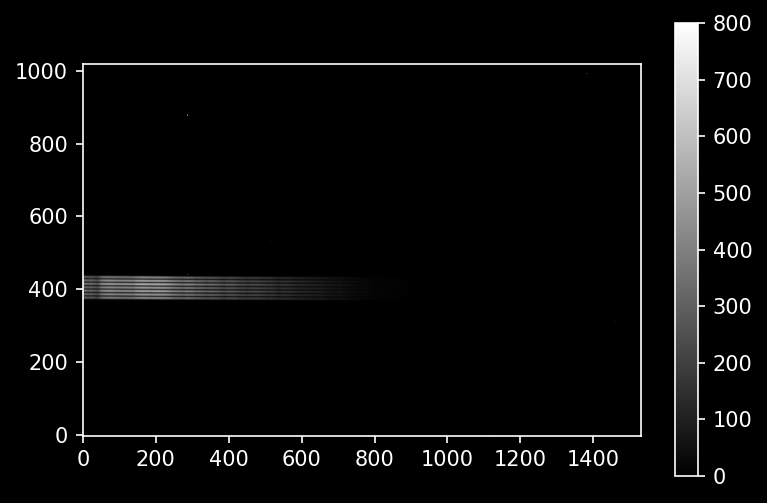

In [4]:
%matplotlib inline
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.dpi'] = 150
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(image_data, cmap='gray', vmax=0, vmin=800)
pl.colorbar()

The main goal of the trace is to obtain a two-dimensional model `f(x)` defining the position of the light along the detector.

We're going to start by assuming that wavelength dispersion is in the X-direction and the Y-direction is entirely spatial.  This is an approximation, but evidently (by looking at the image), it's a decent one.

# Step 1b. Extract a single spectrum to further trace

We can't follow the same process as before because we now have 7 spectra.  We need to trace each of them

We do this by finding linear cuts between the spectra.  This is easiest to do by drawing a line in ds9 and calculating its slope:

In [5]:
# I drew a line between the top two spectra
dy = -3.7
dx = 871
slope = dy/dx

In [6]:
ystart = 365
yend = 441

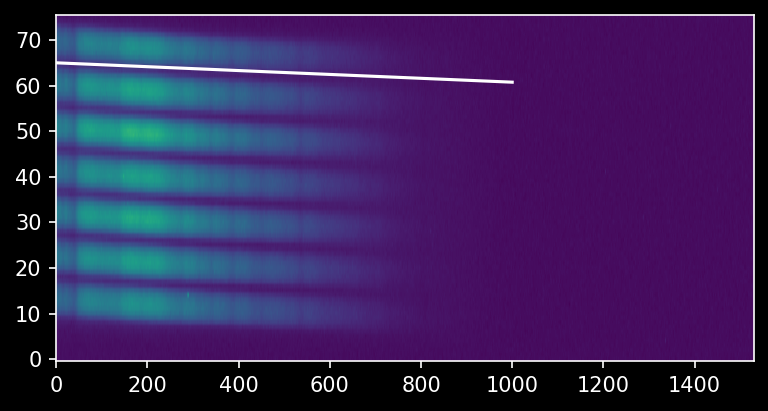

In [7]:
image_array = np.array(image_data)
image_array = image_array - np.median(image_array)
pl.imshow(image_array[ystart:yend,:])
pl.plot([0,1000], 65 + np.array([0,1000]) * slope, color='w')
pl.gca().set_aspect(10)

We can repeat this every _n_ pixels:

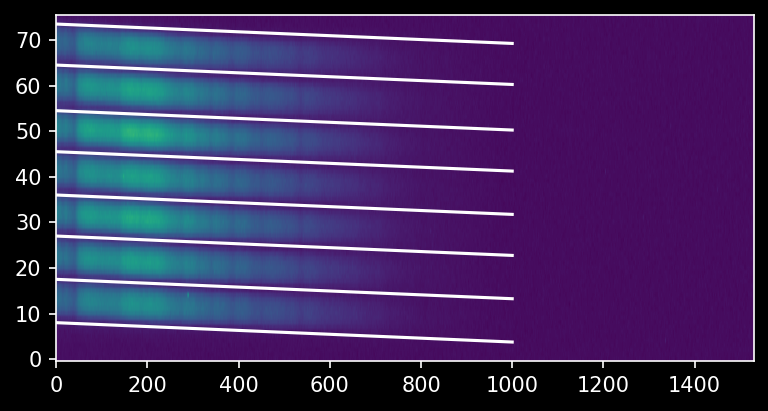

In [8]:
intertrace_cuts = np.array([ 8, 17.5, 27, 36, 45.5, 54.5, 64.5, 73.5])
image_array = np.array(image_data)
image_array = image_array - np.median(image_array)
pl.imshow(image_array[ystart:yend,:])
pl.plot([0,1000], intertrace_cuts + np.array([0,1000])[:,None] * slope, color='w')
pl.gca().set_aspect(10)

We're then going to use the technique from Step 4 below to cut these out:

In [9]:
npixels_to_cut = 4 # very conservative - we'll see why below
xvals = np.arange(image_array.shape[1])
trace_center = ystart+(intertrace_cuts[0] + intertrace_cuts[1])/2 + xvals * slope
cutout_trace = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)]).T
cutout_trace.shape

(8, 1530)

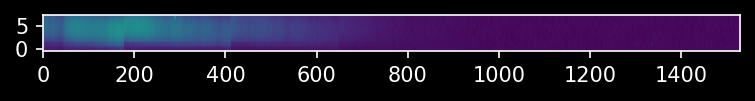

In [10]:
pl.imshow(cutout_trace)
pl.gca().set_aspect(10);

We can now proceed with this somewhat awkward cutout.

# Step 2: Use moment analysis to extract a spine to trace

We can use moments to get measurements of all the data.

Note that we need to subtract off the background to avoid a bias toward the center, so we use the median of the image as our background estimate.

In [11]:
# to get the y-axis values corresponding to each part of our cutout trace, we do the same operation we did on the image
yaxis_full = np.arange(image_array.shape[0])
yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                    for yval, ii in zip(trace_center, xvals)]).T

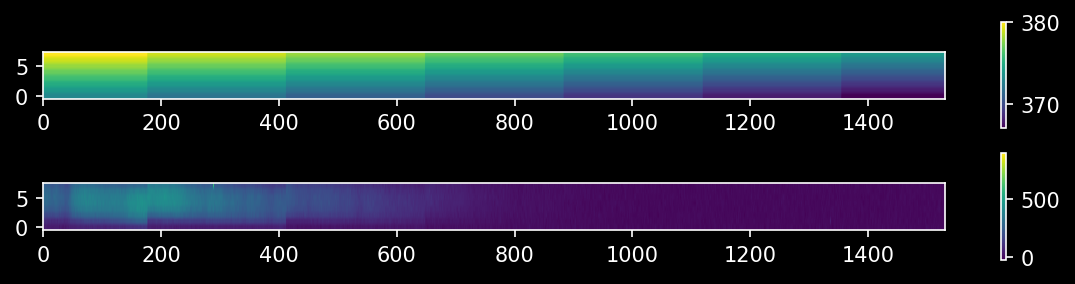

In [12]:
pl.figure(figsize=(8,2))
im = pl.subplot(2,1,1).imshow(yaxis)
pl.colorbar(mappable=im)
pl.gca().set_aspect(10);
im = pl.subplot(2,1,2).imshow(cutout_trace)
pl.colorbar(mappable=im)
pl.gca().set_aspect(10);
pl.tight_layout();

Plot the sum of the trace to see where it cuts off (if the trace sums to zero, it's no good - average will break)

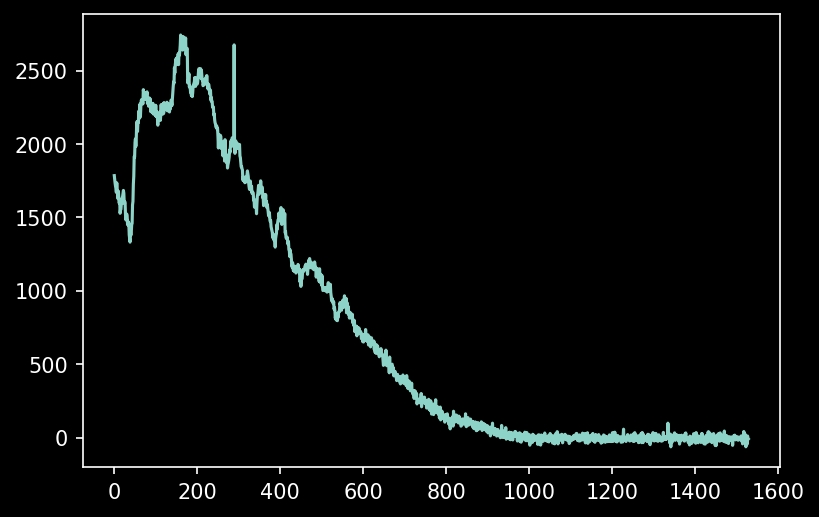

In [13]:
pl.plot(cutout_trace.sum(axis=0))

We slim down the cutout to just the zone with significant detections

In [14]:
# moment 1 is the data-weighted average of the Y-axis coordinates
xend = 800
weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])

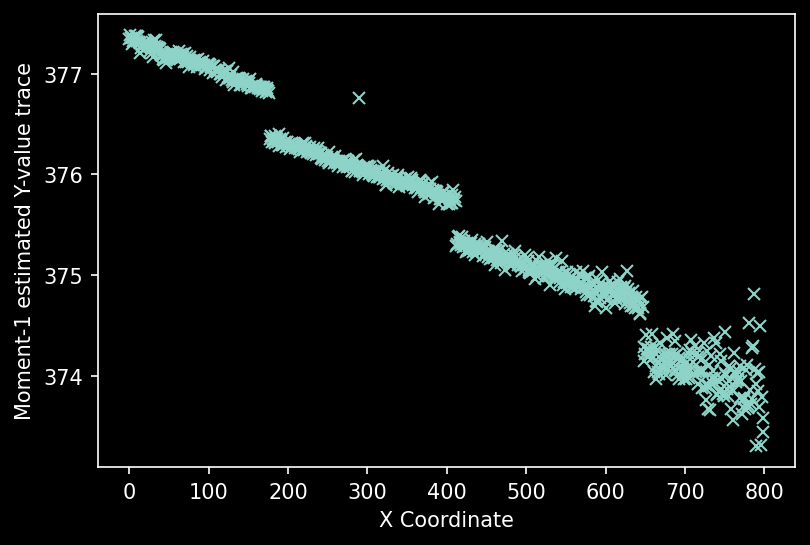

In [15]:
_=pl.plot(xvals[:xend], weighted_yaxis_values, 'x')
_=pl.xlabel("X Coordinate")
_=pl.ylabel("Moment-1 estimated Y-value trace")

Overplot the "weighted", centroid locations on the data to verify they look reasonable.

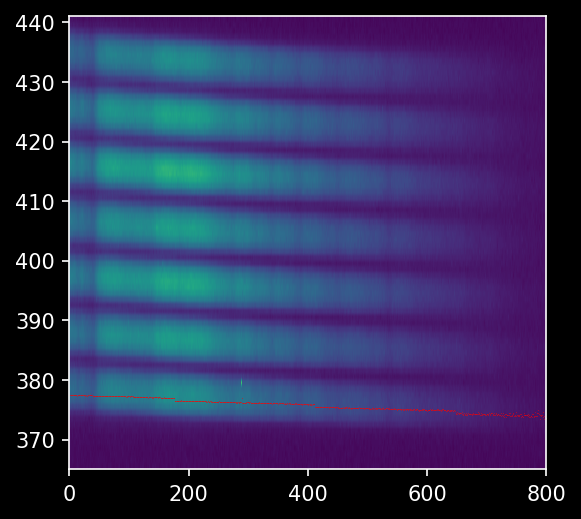

In [16]:
# we need to use the 'extent' keyword to have the axes correctly labeled
_=pl.imshow(image_array[ystart:yend, :xend],
            extent=[0,xend,ystart,yend],
           )
_=pl.gca().set_aspect(10) # we stretch the image out by 10x in the y-direction
_=pl.plot(xvals[:xend], weighted_yaxis_values[:xend], 'r,', alpha=0.5)
_=pl.axis((0,xend,ystart,yend))

We can repeat this for each:

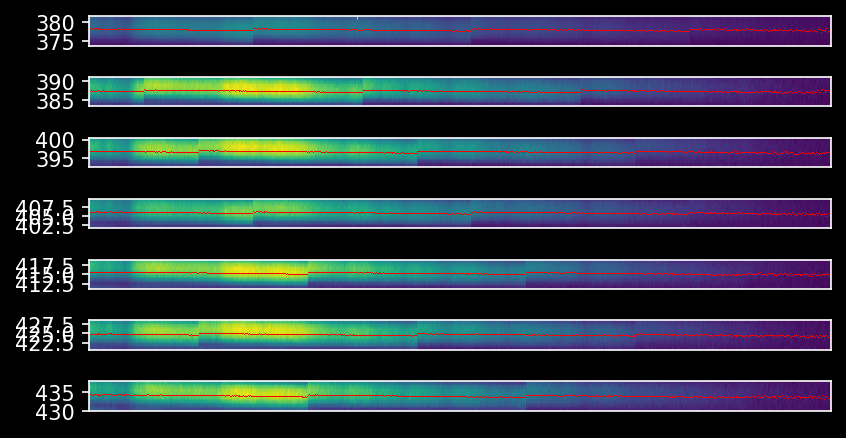

In [17]:
pl.figure(figsize=(8,3))
traces = {}
for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    
    # it takes a little mental gymnastics to get to this, but: to show the trace properly on our cutout,
    # we need to calculate the local version
    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    traces[trace_index] = weighted_yaxis_values
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut])
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(4)
    ax.set_xticks([])
pl.tight_layout()

#  IMPORTANT aside: 
What happens if `npixels_to_cut` is too big?

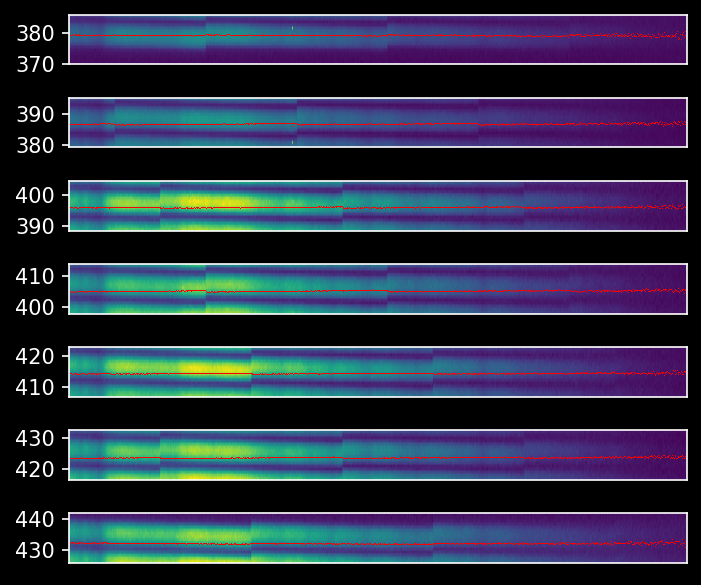

In [18]:
npixels_to_cut_good = npixels_to_cut
npixels_to_cut = 8

for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    

    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut])
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(4)
    ax.set_xticks([])
pl.tight_layout()
npixels_to_cut = npixels_to_cut_good

(0.0, 800.0, 365.0, 441.0)

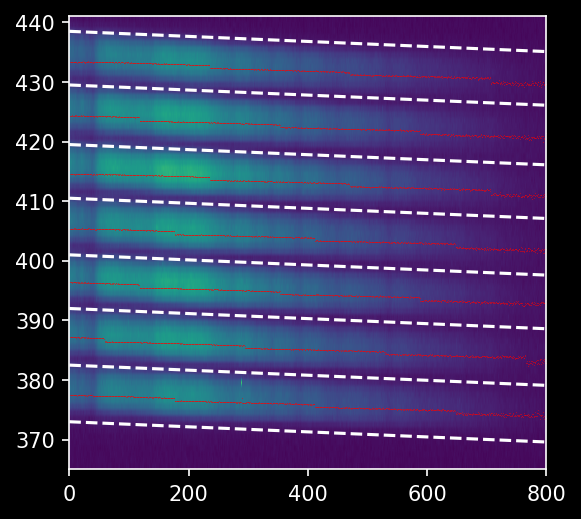

In [19]:
# then we can plot the "global" version here
pl.imshow(image_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for trace in traces.values():
    pl.plot(xvals[:xend], trace[:xend], 'r,', alpha=0.5)
pl.axis((0,xend,ystart,yend))

# Step 3. Fit the trace profile

We want a model `f(x)` that gives the y-value of the centroid as a function of x.

In [20]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

In [21]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

In [22]:
fitted_polymodels

{0: <Polynomial1D(2, c0=377.43055286, c1=-0.00458145, c2=-0.)>,
 1: <Polynomial1D(2, c0=386.86790899, c1=-0.00495945, c2=0.00000048)>,
 2: <Polynomial1D(2, c0=396.26192876, c1=-0.00529218, c2=0.00000074)>,
 3: <Polynomial1D(2, c0=405.35739785, c1=-0.00420823, c2=-0.00000079)>,
 4: <Polynomial1D(2, c0=414.53867029, c1=-0.00315287, c2=-0.00000205)>,
 5: <Polynomial1D(2, c0=424.260403, c1=-0.00518451, c2=0.00000041)>,
 6: <Polynomial1D(2, c0=433.38069598, c1=-0.00361686, c2=-0.00000155)>}

(0.0, 800.0, 365.0, 441.0)

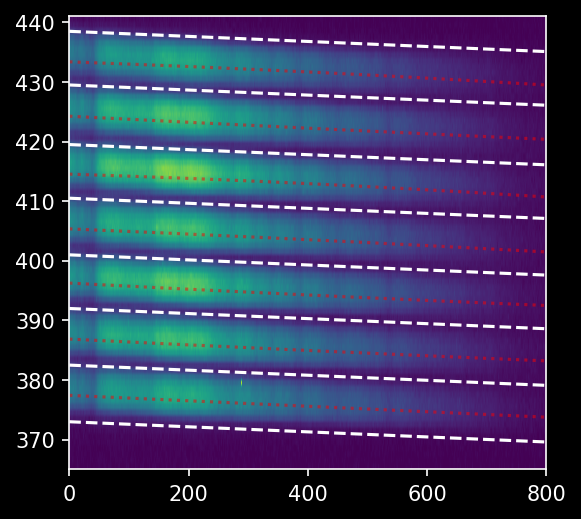

In [23]:
pl.imshow(image_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=700,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

# Step 4. Obtain the trace profile

In [24]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

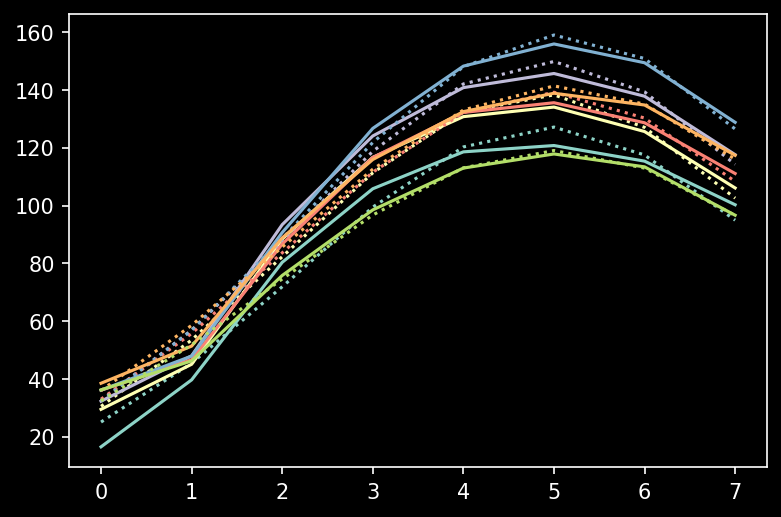

In [25]:
npixels_to_cut_trace = 4

for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([image_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    line, = pl.plot(trace_profile, label=trace_index)
    pl.plot(trace_profile_xaxis, model_trace_profile, color=line.get_color(), linestyle=':')

Now we want to fit that profile with a Gaussian, so we import the Gaussian model profile and non-linear fitter and run a fit:

# Step 5. Extract the traced spectra

In [26]:
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([image_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum

(0.0, 800.0)

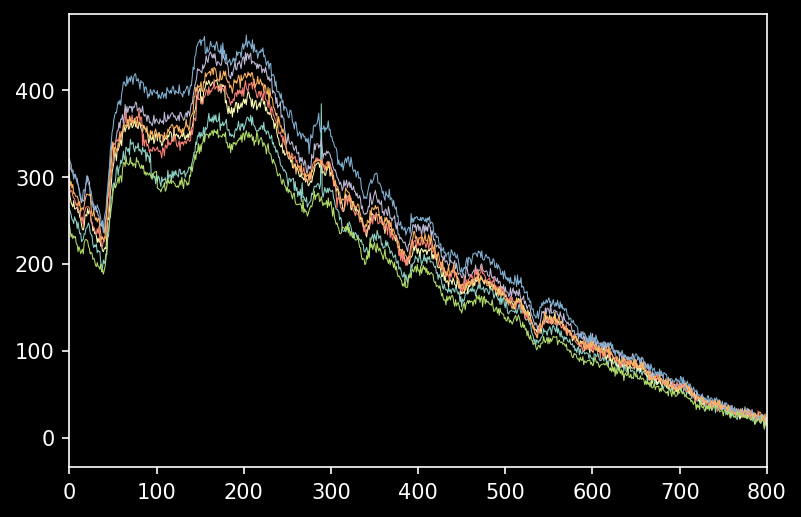

In [27]:
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
pl.xlim(0,800)

In general, the trace-weighted average will have higher signal-to-noise.

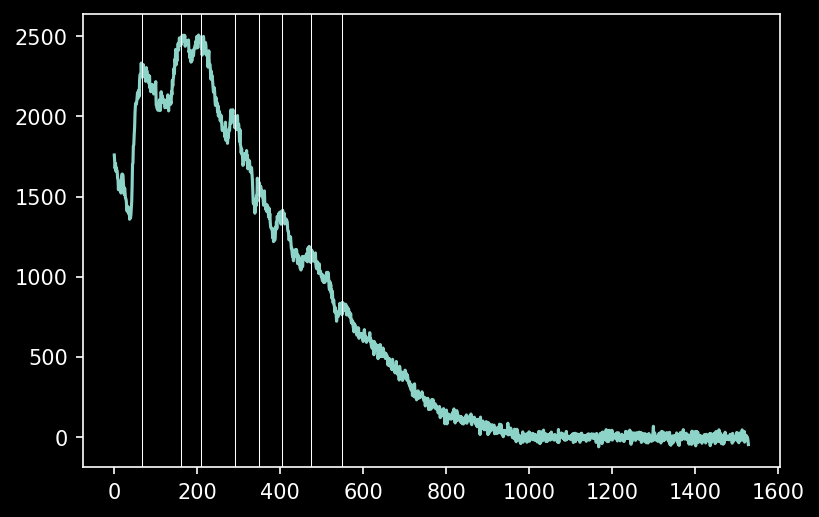

In [151]:
pl.plot(cutout_trace.sum(axis=0))
pl.axvline(x=68 , lw=0.5)
pl.axvline(x=160 , lw=0.5)
pl.axvline(x=210 , lw=0.5)
pl.axvline(x=290 , lw=0.5)
pl.axvline(x=350 , lw=0.5)
pl.axvline(x=405 , lw=0.5)
pl.axvline(x=475 , lw=0.5)
pl.axvline(x=550 , lw=0.5)

Which lines can you see in both the solar spectrum and the calibration lamp spectra?  (hint: you should know the answer to this question from past astronomy classes and should just verify that your expectations are met)

you can probably see magnesium and hydrogen as their lines should be 486 nm for Hydrogen.470 and 550 nm for magnesium

http://www.columbia.edu/~vjd1/Solar%20Spectrum%20Ex.html

# Step 6: Repeat for another file

In [28]:
h1s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\H_1s_clear001_AST4723C_class.FIT"
h5s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\H_5s_clear001_AST4723C_class.FIT"
halogen_clear1s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_blue1s001_AST4723C_class.FIT"
halogen_clear5s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_blue5s001_AST4723C_class.FIT"
halogen_blue1s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_clear1s001_AST4723C_class.FIT"
halogen_blue5s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_clear5s001_AST4723C_class.FIT"
halogen_green1s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_green1s001_AST4723C_class.FIT"
halogen_green5s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_green5s001_AST4723C_class.FIT"
halogen_red1s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_red1s001_AST4723C_class.FIT"
halogen_red5s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_red5s001_AST4723C_class.FIT"
he100ms_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\He_100ms_clear001_AST4723C_class.FIT"
hg1s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\Hg_1s_clear001_AST4723C_class.FIT"
hg5s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\Hg_5s_clear001_AST4723C_class.FIT"
he1s_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\He_100ms_clear001_AST4723C_class.FIT"
ne100ms_filename = "\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\Ne_100ms_clear001_AST4723C_class.FIT"

In [29]:
h1s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\H_1s_clear00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array2 = h1s_image_data

h5s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\H_5s_clear00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array3 = h5s_image_data

halogen1s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_clear1s00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array4 = halogen1s_image_data

halogen5s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\halogen_clear5s00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array5 = halogen5s_image_data

he100ms_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\He_100ms_clear00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array6 = he100ms_image_data

hg1s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\Hg_1s_clear00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array7 = hg1s_image_data

hg5s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\Hg_5s_clear00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array8 = hg5s_image_data

ne100ms_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\Ne_100ms_clear00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array9 = ne100ms_image_data

overhead100ms_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\Overhead_100ms_clear00* AST4723C class.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Data_dropbox_Sep14\\dark_1e-1s00* AST4723C class.FIT")],
                        axis=0)
             )
image_array10 = overhead100ms_image_data

In [30]:
spectra2 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra2[trace_index] = trace_avg_spectrum

(0.0, 800.0)

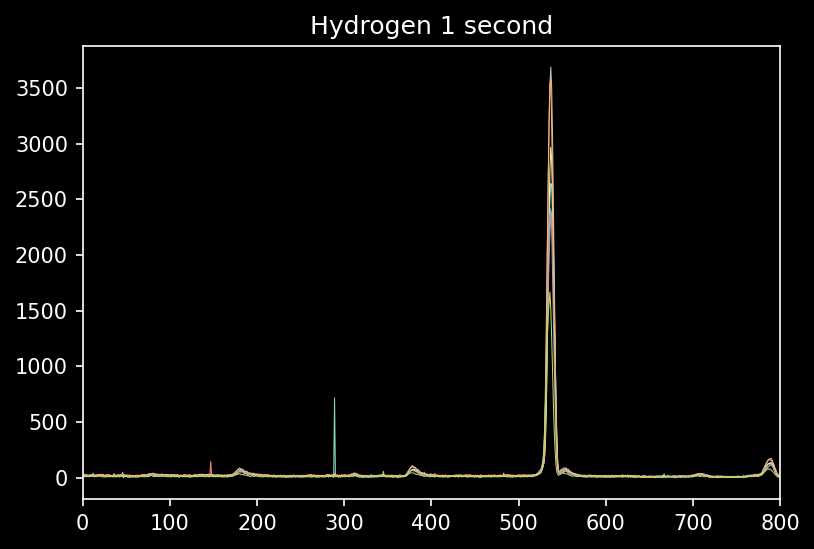

In [31]:
for index in spectra2:
    pl.plot(spectra2[index], linewidth=0.5)
    pl.title('Hydrogen 1 second')
pl.xlim(0,800)

(0.0, 800.0)

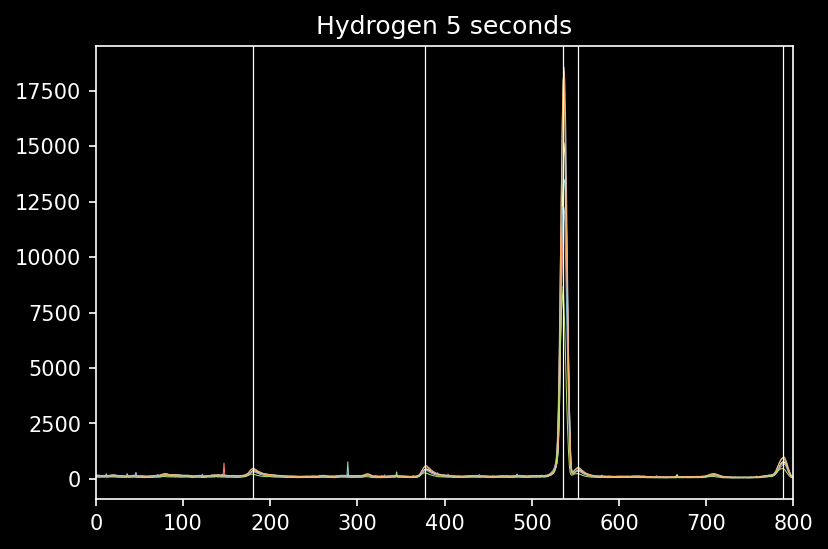

In [63]:
spectra3 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array3[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra3[trace_index] = trace_avg_spectrum
    
for index in spectra3:
    pl.plot(spectra3[index], linewidth=0.5)
    pl.axvline(x=180, lw=0.5)
    pl.axvline(x=378, lw=0.5)
    pl.axvline(x=536, lw=0.5)
    pl.axvline(x=553, lw=0.5)
    pl.axvline(x=788, lw=0.5)
    pl.title('Hydrogen 5 seconds')
pl.xlim(0,800)    

What lines are in the hydrogen spectrum that are not hydrogen?  Report their wavelengths.  (there are at least four prominent ones that you should note, but there may be more)

x lines at wavelengths 


(0.0, 800.0)

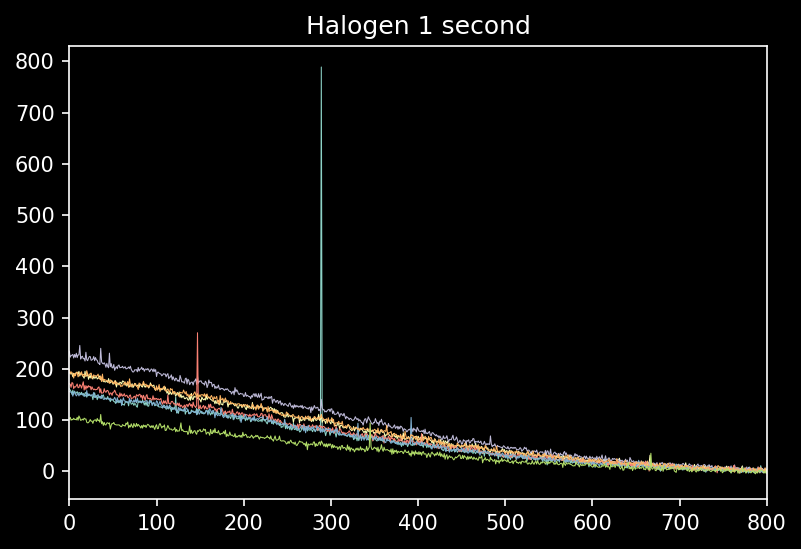

In [33]:
spectra4 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array4[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra4[trace_index] = trace_avg_spectrum
    
for index in spectra4:
    pl.plot(spectra4[index], linewidth=0.5)
    pl.title('Halogen 1 second')
pl.xlim(0,800)  

(0.0, 800.0)

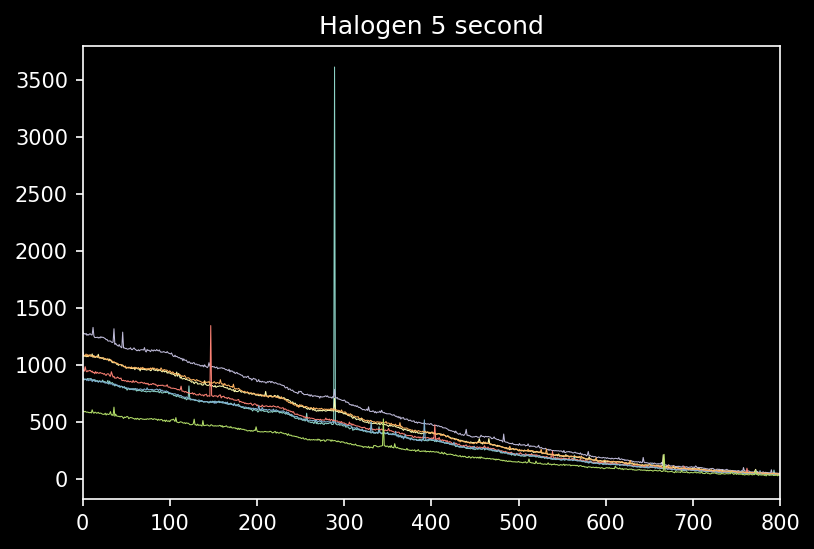

In [34]:
spectra5 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array5[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra5[trace_index] = trace_avg_spectrum
    
for index in spectra5:
    pl.plot(spectra5[index], linewidth=0.5)
    pl.title('Halogen 5 second')
pl.xlim(0,800)

(0.0, 800.0)

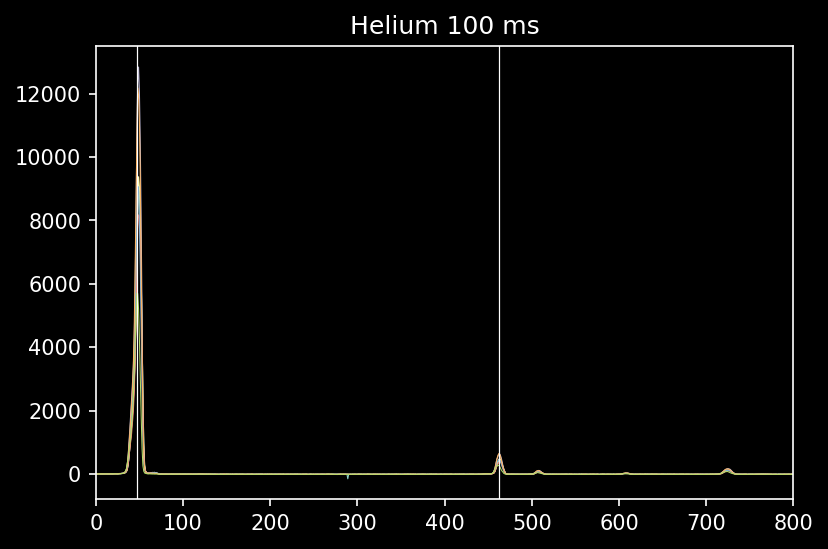

In [70]:
spectra6 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array6[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra6[trace_index] = trace_avg_spectrum
    
for index in spectra6:
    pl.plot(spectra6[index], linewidth=0.5)
    pl.title('Helium 100 ms')
    pl.axvline(x=47, lw=0.5)
    pl.axvline(x=462, lw=0.5)
pl.xlim(0,800)

(0.0, 800.0)

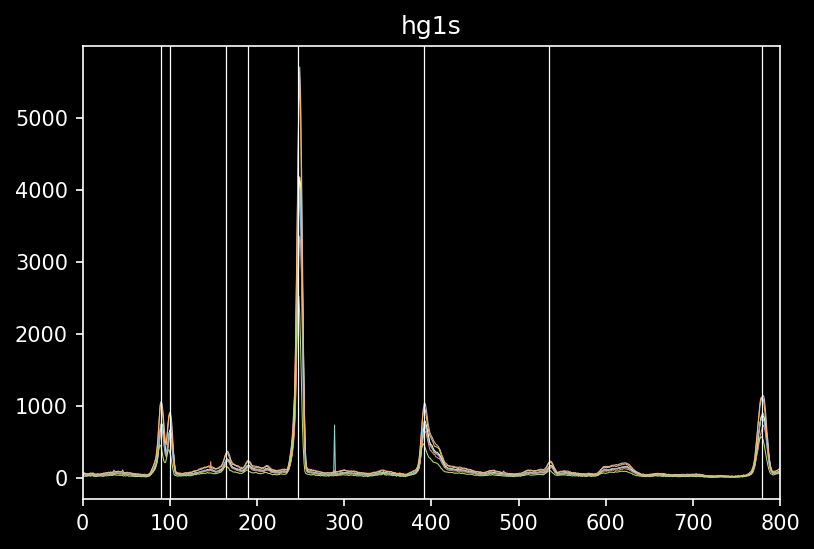

In [99]:
spectra7 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array7[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra7[trace_index] = trace_avg_spectrum
    
for index in spectra7:
    pl.plot(spectra7[index], linewidth=0.5)
    pl.title('hg1s')
    pl.axvline(x=90, lw=0.5)
    pl.axvline(x=100, lw=0.5)
    pl.axvline(x=165, lw=0.5)
    pl.axvline(x=190, lw=0.5)
    pl.axvline(x=247, lw=0.5)
    pl.axvline(x=392, lw=0.5)
    pl.axvline(x=535, lw=0.5)
    pl.axvline(x=779, lw=0.5)
pl.xlim(0,800)

(0.0, 800.0)

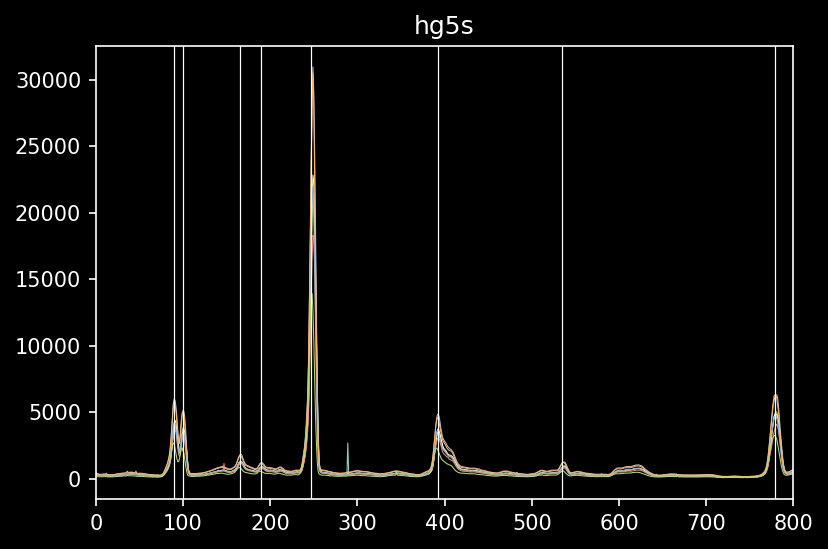

In [100]:
spectra8 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array8[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra8[trace_index] = trace_avg_spectrum
    
for index in spectra8:
    pl.plot(spectra8[index], linewidth=0.5)
    pl.axvline(x=90, lw=0.5)
    pl.axvline(x=100, lw=0.5)
    pl.axvline(x=165, lw=0.5)
    pl.axvline(x=190, lw=0.5)
    pl.axvline(x=247, lw=0.5)
    pl.axvline(x=392, lw=0.5)
    pl.axvline(x=535, lw=0.5)
    pl.axvline(x=779, lw=0.5)
    pl.title('hg5s')
pl.xlim(0,800)

(0.0, 800.0)

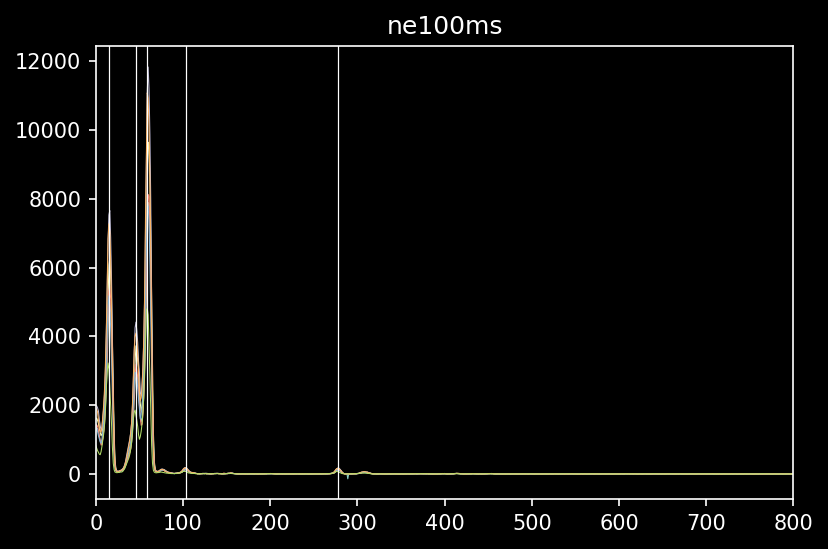

In [117]:
spectra9 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array9[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra9[trace_index] = trace_avg_spectrum
    
for index in spectra9:
    pl.plot(spectra9[index], linewidth=0.5)
    pl.axvline(x=15, lw=0.5)
    pl.axvline(x=46, lw=0.5)
    pl.axvline(x=59, lw=0.5)
    pl.axvline(x=103, lw=0.5)
    pl.axvline(x=278, lw=0.5)
    pl.title('ne100ms')
pl.xlim(0,800)

(0.0, 800.0)

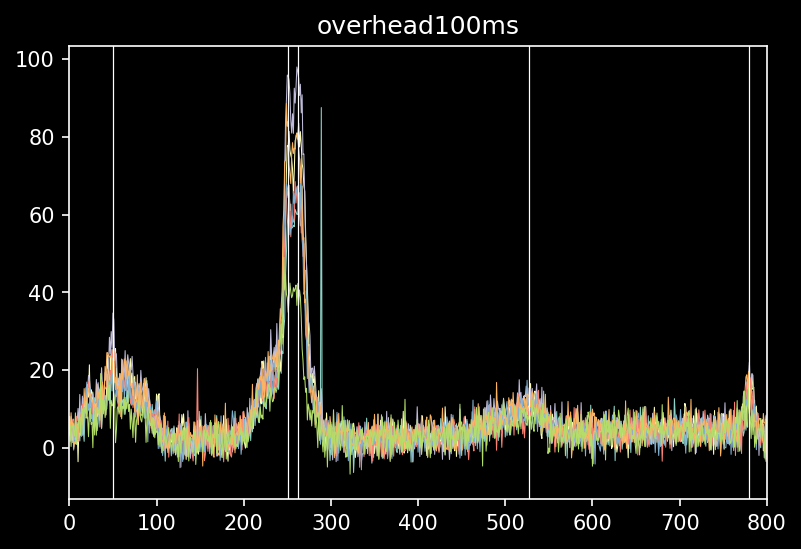

In [166]:
spectra10 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            image_array10[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    spectra10[trace_index] = trace_avg_spectrum
    
for index in spectra10:
    pl.plot(spectra10[index], linewidth=0.5)
    pl.title('overhead100ms')
    pl.axvline(x=50 , lw=0.5)
    pl.axvline(x=251 , lw=0.5)
    pl.axvline(x=262 , lw=0.5) 
    pl.axvline(x=527 , lw=0.5) 
    pl.axvline(x=780 , lw=0.5)
    pl.axvline(x=68 , lw=0.5)


pl.xlim(0,800)

What lines are in the overhead lamp spectrum?  Can you identify any ingredients of the lamp?  (there are at least two identifiable lines, plus a few others that might be detectable if they're not too broad)

magnesium, hydrogen, maybe iron

http://www.columbia.edu/~vjd1/Solar%20Spectrum%20Ex.html

Measure again: What is the angle of the system, based on the calculations you did in your lab and the central wavelength of these data?  Is it different from what you turned in previously?  If so, by how much?  Speculate on why!

In [175]:
#lam = np.median(cutout_trace.sum(axis=0))
#lam = np.median(model_trace_profile)
#lam=np.median(yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend])

In [193]:
lam2 = np.median(trace_avg_spectrum) # median of the average spectrum, makes most sense but is two decimals off in degrees

In [194]:
lam = np.median(tracefit(xvals[:xend])) # closest to what I expect the value to be 

In [195]:
# en
D = 830 

ne_ang = np.arcsin(lam/D)
ne_ang = ne_ang*u.rad
ne_ang.to(u.deg)

<Quantity 31.33934345 deg>

In [197]:
# probably right but unit off 
D = 830 

ne_ang = np.arcsin((lam2*100)/D)
ne_ang = ne_ang*u.rad
ne_ang.to(u.deg)

<Quantity 27.67471437 deg>

this is probably wrong. Commented are other methods I tried for lambda. I wasn't too sure which value to use for the lambda value